## National Institute for Space Research
   <img src="img/icone_cap394.svg" align="right" alt="Drawing" style="width: 200px;"/>
   
#### Project for course  Introduction to Data Science - CAP 394
#### Student: 
* Helvecio Bezerra Leal Neto

#### Instructors: 
* Dr. Gilberto Queiroz 
* Dr. Rafael Santos

## Schedule
     - [x] Data reading
     - [x] Data visualization
     - [x] Cluster detection algorithm
     - [x] Preprocessing
     - [ ] Final analysis and project elaboration

### Index

  [About](#about) <br></br>
  [The Data](#the_data)<br></br>
  [Reading Data](#reading_data)<br></br>

<a id='about'></a>
## About

This work is part of the suite of applications for the Introduction to Data Science (CAP-394) course offered by the National Institute for Space Research.

The purpose of this paper is to perform an exploratory analysis on Radar data by surveying the raw data, processing them and understanding the dynamics of cloud movement in the study region. At the end of the exploratory process it will be possible to estimate the behavior of the clouds in relation to their movement, making an algorithm capable of estimating the movement from two consecutive images.

<a id='the_data'></a>
## The Data

The data analyzed in this example consists of NC (NetCDF4) files. Each file corresponds to Rain Rate measurements collected by the Amazon Protection System (SIPAM) radar during the GoAmazon experiment periods, starting from January 2014 to December 2015, such files contain data on 12-minute time intervals.

https://www.arm.gov/research/campaigns/amf2014goamazon

<a id='reading_data'></a>
## Reading Data

#### 1.1 - Libraries used

In [111]:
import datetime
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.basemap import Basemap
from matplotlib import animation
from matplotlib import markers
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#%matplotlib
%matplotlib inline

#### 1.2 Openning dataset

In [2]:
day = 20140103

#read first file to extract static variable values
path = 'data/radar/'
first_file = path+str(day)+'/'+str(os.listdir(path+str(day))[0])
    
xds = xr.open_dataset(first_file)

rr = xds.rain_rate                  ### Matrix with preciptation values
runit = xds.rain_rate.units         ### Unit of rain_rate mm/h
rkm = xds.rain_rate.height_km       ### Unit of matrix dimensions km
lon = xds.lon0.data                 ### Coordinate Longitude Matrix
lat = xds.lat0.data                 ### Corrdinate Latitude Matrix
x0 = xds.x0                         ### Matrix of points
y0 = xds.y0

In [3]:
xds

<xarray.Dataset>
Dimensions:     (x0: 241, y0: 241)
Dimensions without coordinates: x0, y0
Data variables:
    start_time  datetime64[ns] ...
    stop_time   datetime64[ns] ...
    lat0        (y0, x0) float32 -5.3025093 -5.302555 ... -0.99165195 -0.9916234
    lon0        (y0, x0) float32 -62.156715 -62.138676 ... -57.854195 -57.83623
    rain_rate   (y0, x0) float32 ...
Attributes:
    description:  SIPAM Manaus S-Band Gridded Rain Rates
    source:       SIPAM Manaus S-Band Radar
    institution:  SIPAM/Texas A&M University
    comment:      v2.0a; Created at Texas A&M University (cschu@tamu.edu)
    references:   http://atmo.tamu.edu/goamazon-sband-radar
    created:      Tue Sep  5 14:22:48 2017\n

#### 1.3 Variables present in the dataset

In [4]:
xds.data_vars

Data variables:
    start_time  datetime64[ns] ...
    stop_time   datetime64[ns] ...
    lat0        (y0, x0) float32 -5.3025093 -5.302555 ... -0.99165195 -0.9916234
    lon0        (y0, x0) float32 -62.156715 -62.138676 ... -57.854195 -57.83623
    rain_rate   (y0, x0) float32 ...

#### 1.4 Attributes from dataset

In [5]:
xds.attrs

OrderedDict([('description', 'SIPAM Manaus S-Band Gridded Rain Rates'),
             ('source', 'SIPAM Manaus S-Band Radar'),
             ('institution', 'SIPAM/Texas A&M University'),
             ('comment',
              'v2.0a; Created at Texas A&M University (cschu@tamu.edu)'),
             ('references', 'http://atmo.tamu.edu/goamazon-sband-radar'),
             ('created', 'Tue Sep  5 14:22:48 2017\n')])

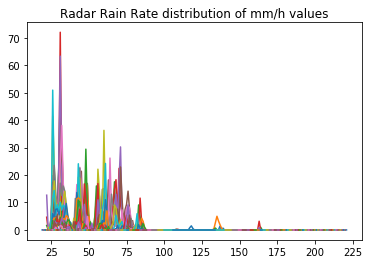

In [6]:
plt.plot(rr)
plt.title('Radar Rain Rate distribution of mm/h values')
plt.show()

#### 1.5 Read all data

In [7]:
def readData(date):
    
    path = 'data/radar/'
    dataset = []
    interval = len(os.listdir(path+str(date)))    
    
    # Original grid dimensions
    nx = 241
    ny = 241

    # pixel size (in meters)
    dx = 1000.
    dy = 1000.

    downsizeby = 1    
    
    # Compute grid dimensions and grid coordinates after resampling
    dx2, dy2 = dx*downsizeby, dy*downsizeby
    nx2, ny2 = int(nx/downsizeby), int(ny/downsizeby)

    X2, Y2 = np.meshgrid( np.arange(0,nx2*dx2, dx2), np.arange(0,ny2*dy2, dy2) )

    # Define container
    frames = np.zeros( (interval, nx2, ny2 ) )    
    
    for i in range(interval):
        d = str(path)+str(date)+'/'
        file = (sorted(os.listdir(path+str(date)))[i])
        xds = xr.open_dataset(d+file)
        rr = xds.rain_rate
        frames[i] =  rr
            
    return frames

In [8]:
frames = readData(day)
print('The frames from dataset: (times,x,y) -> ',frames.shape)

The frames from dataset: (times,x,y) ->  (104, 241, 241)


#### 1.6 Plot simple example without colormap legends for Time Zero

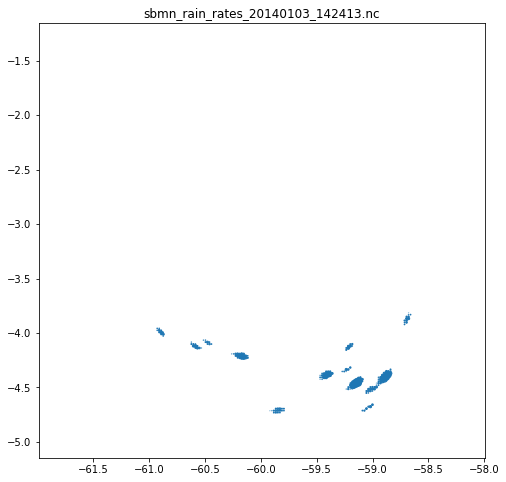

In [88]:
## Plot simple figure from dataset

figtime = 56

filename = sorted(os.listdir(path+str(day)))[figtime]

plt.figure(figsize=(8,8))
plt.title(filename)
plt.scatter(lon,lat,frames[figtime])
#plt.pcolormesh(lon,lat,frames[figtime])

#### 1.7 Clusterization

In [102]:
def clust(time1):    #11.53:
    
    dx ,dy = [],[]
    te = None
    
    for i in range(241):
        for j in range(241):
            if not np.isnan(frames[time1][i][j]) and frames[time1][i][j] > 11.53:
                dx.append(i)
                dy.append(j)

    dim = len(dx)
    
    # Check dimension
    if dim > 4:   
        for x in range(dim):
            dx.append(np.float32('nan'))
            dy.append(np.float32('nan'))

        matrix = np.ndarray(shape=(dim, 2), dtype='float32')
        pt = pd.DataFrame(columns=['x1','y1'])
    
        for x in range(dim):
            matrix[x] = (dx[x], dy[x])
            pt['x1'] = matrix[:,0]
            pt['y1'] = matrix[:,1]
        
        te = pt[['x1','y1']]
          
        #bandwidth = estimate_bandwidth(te, quantile=0.3)
        ms = MeanShift(bandwidth=2, bin_seeding=True, cluster_all=True, min_bin_freq=1,
         n_jobs=None, seeds=None)

        ms.fit(te)
        labels = ms.labels_
        cluster_centers = ms.cluster_centers_
        n_clusters_ = len(np.unique(labels))
        
#     colors = 10*['r.','g.','b.','c.','k.','y.','m.']
#     for i in range(len(te)):
#            #print(te['x1'][i])
#         plt.plot(te['x1'][i], te['y1'][i], colors[labels[i]], markersize = 10)
#         plt.title('Estimated number of clusters: %d' % n_clusters_)

# #         kmeans = KMeans().fit(te)
# #         labels = kmeans.labels_
# #         cluster_centers = kmeans.cluster_centers_
# #         n_clusters_ = len(np.unique(labels))

        te['cluster']=labels
    
    return te

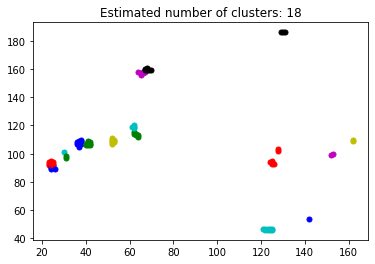

In [101]:
clusters = clust(80)

In [13]:
def createData(time,clusters):

    FAM1 = pd.DataFrame(columns=['YEAR','MONTH','DAY','HOUR','MINUTE','N_Cluster','ID_CLUS','LAT','LON','IND_X','IND_Y','RAIN_FALL'])

    #SELECT CLUSTER TIME IS DIFFERENT ZERO VALUES FROM COLUMN X1
    fam1_ = clusters.loc[clusters['x1'] != 0]

    LAT_ = (lat[fam1_['x1'].astype(int),fam1_['y1'].astype(int)])
    LON_ = (lon[fam1_['x1'].astype(int),fam1_['y1'].astype(int)])
    N_CLUST = len(fam1_['cluster'].unique())

    rfall = []
    for i in range(len(fam1_['x1'].astype(int))):
        rfall.append(frames[time][fam1_['x1'][i].astype(int)][fam1_['y1'][i].astype(int)])

    FAM1['IND_X'], FAM1['IND_Y'] = fam1_['x1'],fam1_['y1']
    FAM1['LAT'],FAM1['LON'] = LAT_,LON_
    FAM1['N_Cluster'] = N_CLUST
    FAM1['ID_CLUS'] = fam1_['cluster']
    FAM1['RAIN_FALL'] = rfall
    FAM1['YEAR'] = str(sorted(os.listdir(path+str(day)))[time])[16:20]
    FAM1['MONTH'] = str(sorted(os.listdir(path+str(day)))[time])[20:22]
    FAM1['DAY'] = str(sorted(os.listdir(path+str(day)))[time])[22:24]
    FAM1['HOUR'] = str(sorted(os.listdir(path+str(day)))[time])[22:24]
    FAM1['MINUTE'] = str(sorted(os.listdir(path+str(day)))[time])[27:29]

    return FAM1

In [14]:
createData(90,clusters)

,YEAR,MONTH,DAY,HOUR,MINUTE,N_Cluster,ID_CLUS,LAT,LON,IND_X,IND_Y,RAIN_FALL
0,2014,01,03,03,12,22,21,-4.729900,-60.875244,32.0,71.0,17.634233
1,2014,01,03,03,12,22,21,-4.711898,-60.911274,33.0,69.0,17.358810
2,2014,01,03,03,12,22,14,-4.693986,-60.857182,34.0,72.0,13.190619
3,2014,01,03,03,12,22,14,-4.694004,-60.839157,34.0,73.0,15.455812
4,2014,01,03,03,12,22,14,-4.694020,-60.821133,34.0,74.0,11.998159
5,2014,01,03,03,12,22,11,-4.694068,-60.767059,34.0,77.0,14.100288
6,2014,01,03,03,12,22,11,-4.694084,-60.749035,34.0,78.0,12.109049
7,2014,01,03,03,12,22,21,-4.675949,-60.929256,35.0,68.0,22.895527
8,2014,01,03,03,12,22,12,-4.675985,-60.893208,35.0,70.0,12.451838
9,2014,01,03,03,12,22,12,-4.676003,-60.875187,35.0,71.0,15.476634


#### 1.8 Pre-processing

In [15]:
day = 20140103 

def run():
    data = readData(day)
    
    total = []
    
    for i in range(len(data)):
        cluster = clust(i)
        
        if isinstance(cluster,pd.DataFrame):
            data = createData(i,cluster)
        #total.append(createData)
        
            data.to_csv('output/OUTPUT_'+str(sorted(os.listdir(path+str(day)))[i][:-3])+'.csv')
            print('Data Frame ',i, 'Created')
        del cluster
        
    #return total

In [ ]:
run()

In [103]:
#### SETUP FOR PLOT

time = 80


centroid = []
centers = clust(time)

if isinstance(centers,pd.DataFrame):

    centers = createData(time,centers)
    c_lat = centers['LAT']
    c_lon = centers['LON']

    for i in range(centers['N_Cluster'].max()):
        ct = centers.loc[centers['ID_CLUS'] == i ]
        ct = ct.loc[ct['RAIN_FALL'] == ct['RAIN_FALL'].max()]
        centroid.append(ct)
    print(centroid[1])
    
file = path+str(day)+'/'+str(sorted(os.listdir(path+str(day)))[time])
xds = xr.open_dataset(file)
date_time = xds.start_time.data
date_time = pd.to_datetime(date_time)

    YEAR MONTH DAY HOUR MINUTE  N_Cluster  ID_CLUS       LAT       LON  IND_X  \
33  2014    01  03   03     12         18        1 -4.568613 -60.20826   41.0   

    IND_Y  RAIN_FALL  
33  108.0  24.434757  


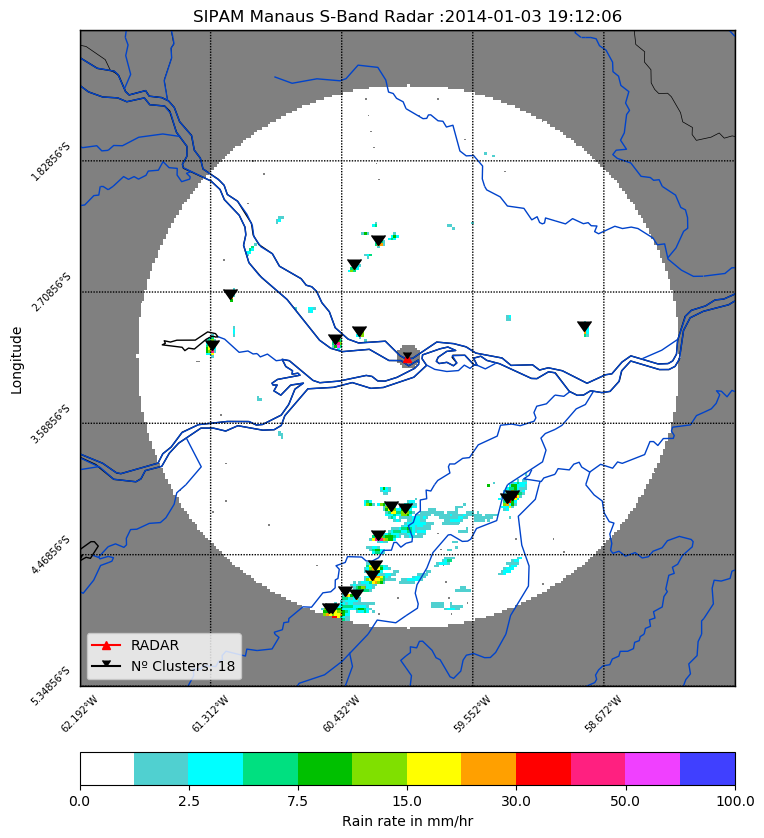

In [120]:
 ## Extract Centers from FRAME time
    
my_coords = [-3.148556, -59.992000]     ## RADAR T1 SIPAM COORDS
zoom_scale = 2.2                        ## ZOOM SCALE

bbox = [my_coords[0]-zoom_scale,my_coords[0]+zoom_scale,\
         my_coords[1]-zoom_scale,my_coords[1]+zoom_scale]


fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,10),dpi=100)
label = 'Rain rate in ' + runit+ ''
title = 'SIPAM Manaus S-Band Radar :' + str(date_time)

# draw filled contours.
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
             50, 70, 100]

cmap_data = [(1.0, 1.0, 1.0),
                 (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
                 (0.0, 1.0, 1.0),
                 (0.0, 0.8784313797950745, 0.501960813999176),
                 (0.0, 0.7529411911964417, 0.0),
                 (0.501960813999176, 0.8784313797950745, 0.0),
                 (1.0, 1.0, 0.0),
                 (1.0, 0.6274510025978088, 0.0),
                 (1.0, 0.0, 0.0),
                 (1.0, 0.125490203499794, 0.501960813999176),
                 (0.9411764740943909, 0.250980406999588, 1.0),
                 (0.501960813999176, 0.125490203499794, 1.0),
                 (0.250980406999588, 0.250980406999588, 1.0)]

cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)
ax = axes

m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
                llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

## PRECIPTACAO
xi, yi = m(lon, lat)
## SIPAM RADAR
xm, ym = m(my_coords[1],my_coords[0])
radar = m.plot(xm,ym, marker='^',color='r', label='RADAR')


for cent in range(len(centroid)):
    clat, clon, mm_f = centroid[cent]['LAT'].item(),centroid[cent]['LON'].item(),centroid[cent]['RAIN_FALL'].item()

    t3x,t3y = m(clon, clat)
    m.plot(t3x,t3y, marker=markers.CARETDOWN, markersize=10, color='k')
    #plt.annotate(str(mm_f)[0:5]+'mm/h', xy=(t3x,t3y),xytext=(t3x+12,t3y+12),rotation=45, size=10)
    
m.plot(xm,ym, label='Nº Clusters: ' +str(len(centroid)),marker=markers.CARETDOWN, color='k')

cs = m.pcolormesh(xi,yi,frames[time], cmap = cmap, norm = norm, ax=ax)

# # # # Add Grid Lines
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0],rotation=45, size=(7))
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45, size=(7))
m.drawmapboundary(fill_color='gray')

m.drawcoastlines()
m.drawstates()
m.drawcountries()
#m.fillcontinents(color='#FAFAFA',lake_color='dodgerblue')
#m.drawlsmask(land_color='Linen', lake_color='#CCFFFF')
m.drawrivers(color = '#0043CB', linewidth=1)

#m.readshapefile('./data/am_municipios/13MUE250GC_SIR', 'teste')
# # # # Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label(label)

# # # # # Add Title
plt.title(title)
plt.legend()
plt.ylabel('Longitude', labelpad=40)
plt.xlabel('Latitude', labelpad=60)

plt.savefig('tempo102.png')

plt.show()

In [ ]:
from lib.radar_plot import radar_plot
img = radar_plot(rr=frames[0],runit=runit,lat=lat,lon=lon)

#### 1.7 Function for create Animation (Giff File in root dir)

In [ ]:
def createGiff():
    my_coords = [-3.148556, -59.992000]     ## RADAR T1 SIPAM COORDS
    zoom_scale = 2.2                        ## ZOOM SCALE

    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,10),dpi=100)

    # draw filled contours.
    clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
                 50, 70, 100]

    cmap_data = [(1.0, 1.0, 1.0),
                     (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
                     (0.0, 1.0, 1.0),
                     (0.0, 0.8784313797950745, 0.501960813999176),
                     (0.0, 0.7529411911964417, 0.0),
                     (0.501960813999176, 0.8784313797950745, 0.0),
                     (1.0, 1.0, 0.0),
                     (1.0, 0.6274510025978088, 0.0),
                     (1.0, 0.0, 0.0),
                     (1.0, 0.125490203499794, 0.501960813999176),
                     (0.9411764740943909, 0.250980406999588, 1.0),
                     (0.501960813999176, 0.125490203499794, 1.0),
                     (0.250980406999588, 0.250980406999588, 1.0)]
    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    norm = mcolors.BoundaryNorm(clevs, cmap.N)
    ax = axes

    label = 'Rain rate in ' + runit
    title = os.listdir(datadir+str(ddate))[0]


    ## BASEMAP
    bbox = [my_coords[0]-zoom_scale,my_coords[0]+zoom_scale,\
            my_coords[1]-zoom_scale,my_coords[1]+zoom_scale]

    m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
                llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

    ## SIPAM RADAR
    xm, ym = m(my_coords[1],my_coords[0])
    radar = m.plot(xm,ym, marker='^',color='r', label='RADAR')

    # # # # Add Grid Lines
    m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0],rotation=45, size=(7))
    m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45, size=(7))
    m.drawmapboundary(fill_color='gray')

    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    m.drawrivers(color = '#0043CB', linewidth=1)

    # # # # # Add Title
    plt.title(title)
    plt.legend()
    plt.ylabel('Longitude', labelpad=40)
    plt.xlabel('Latitude', labelpad=60)

    #CLOUDS
    xi, yi = m(lon, lat)
    cs = m.pcolormesh(xi,yi,frames[0],cmap = cmap, norm = norm, ax=ax)
    cs = m.pcolormesh(xi,yi,rr)

    def init():
        return cs,

    def animate(i):
        plt.title('Tempo: ' + str(i) + ' File: '+sorted(os.listdir(datadir+str(ddate)))[i])#)
        m.pcolormesh(xi,yi,frames[i],cmap = cmap, norm = norm, ax=ax)
        return cs,

    # # # # # Add Colorbar
    cbar = m.colorbar(cs, location='bottom', pad="10%")
    cbar.set_label(label)

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=interval,  blit=True, repeat=True, save_count=interval)
    anim.save(os.listdir(datadir+str(ddate))[0]+'.gif', writer='imagemagick', fps=1)

In [ ]:
#     clusters = []
        
#     clus = pd.DataFrame(columns = ['N_Cluster','LON','LAT','IND_X','IND_Y','PRECIPIT'])

#     for i in range(len(matrix)):
#         clus = clus.append({'N_Cluster': labels[i],
#                                'LON': lon[(int(matrix[i][0]),int(matrix[i][1]))],
#                                'LAT': lat[(int(matrix[i][0]),int(matrix[i][1]))],
#                                'IND_X': matrix[i][0],
#                                'IND_Y': matrix[i][1],
#                                'PRECIPIT': frames[time1][int(matrix[i][0])][int(matrix[i][1])]},ignore_index=True)              
    #print(n_clusters_)
    #print(cluster_centers)
    #colors = 10*['r.','g.','b.','c.','k.','y.','m.']

#     for i in range(len(pt)):
#         plt.plot(pt['x1'], pt['y1'], colors[labels[i]], markersize = 10)
                                         
        #plt.annotate(i,(cluster_centers[:,1], cluster_centers[:,0]),ha='center')

    #plt.scatter(pt['x1'],pt['y1'],c=labels)
    
    
        
#         for i in range(len(matrix2)):
#             plt.plot(matrix2[i][1], matrix2[i][0], colors[labels[i]], markersize = 10)

#     plt.title('Estimated number of clusters: %d' % n_clusters_)    
        
#     #plt.scatter(cluster_centers[:,1], cluster_centers[:,0],
#     #            marker = 'x', s=150, linewidths=10, zorder=10)
        
#      for i, txt in enumerate(range(n_clusters_)):
#             plt.annotate(txt,(cluster_centers[i,1],cluster_centers[i,0]),textcoords="offset points",xytext=(0,10),ha='center')

# #     plt.show()
        
#     return clus

In [ ]:
### CLUSTERING IN TWO TIMES

def clusterization(time1,time2):    
    
    dx ,dy = [],[]
    dx2 ,dy2 = [],[]
    te = None
    
    for i in range(241):
        for j in range(241):
            if not np.isnan(frames[time1][i][j]) and frames[time1][i][j] > 11.53:
                dx.append(i)
                dy.append(j)
                
    for i in range(241):
        for j in range(241):
            if not np.isnan(frames[time2][i][j]) and frames[time2][i][j] > 11.53:
                dx2.append(i)
                dy2.append(j)                

    dim = len(dx)
    dim2 = len(dx2)
    
    # Check dimension
    if dim > 4 and dim2 >4:   
    
        if dim < dim2:
            for x in range(abs(dim-dim2)):
                dx.append(np.float32('nan'))
                dy.append(np.float32('nan'))
            dim = dim2
        elif dim2 < dim:
            for x in range(abs(dim-dim2)):
                dx2.append(np.float32('nan'))
                dy2.append(np.float32('nan'))
            dim2 = dim

        matrix = np.ndarray(shape=(dim, 2), dtype='float32')
        matrix2 = np.ndarray(shape=(dim2, 2), dtype='float32')


        for x in range(dim):
            matrix[x] = (dx[x], dy[x])

        for x2 in range(dim2):
            matrix2[x2] = (dx2[x2], dy2[x2])
            

        pt = pd.DataFrame(columns=['x1','y1','x2','y2'])
        

        pt['x1'] = matrix[:,0]
        pt['y1'] = matrix[:,1]
        pt['x2'] = matrix2[:,0]
        pt['y2'] = matrix2[:,1]
        
        te = pt[['x1','y1','x2','y2']]
        te = te.fillna(0)    

        bandwidth = estimate_bandwidth(te, quantile=0.3)
        ms = MeanShift(bandwidth=bandwidth)
        ms.fit(te)
        labels = ms.labels_
        cluster_centers = ms.cluster_centers_
        n_clusters_ = len(np.unique(labels))        

#         kmeans = KMeans().fit(te)
#         labels = kmeans.labels_
#         cluster_centers = kmeans.cluster_centers_
#         n_clusters_ = len(np.unique(labels))

        te['cluster']=labels
    
    return te

In [ ]:
day = 20140103 

def run():
    data = readData(day)
    
    for i in range(1,len(data),1):
        
        cluster = clusterization(i-1,i)

        if isinstance(cluster,pd.DataFrame):
            #print(i-1,i,len(cluster['cluster'].unique()))
            
            fam1_ = cluster.loc[cluster['x1'] != 0]
            fam2_ = cluster.loc[cluster['x2'] != 0]
            
            print('Temp: ',i-1, ' Clusters: ',len(fam1_['cluster'].unique()),
                  'Temp: ',i, ' Clusters: ',len(fam2_['cluster'].unique()))
            
            fam1_ = 0
            fam2_ = 0
            
            
            #clus = pd.DataFrame(columns = ['N_Cluster','LON','LAT','IND_X','IND_Y','PRECIPIT'])
            #print(clus)
            
            
            
        else:
            print('Temp: ',i-1, 'Clusters: 0',' Temp: ',i, 'Clusters: 0')
        #print(data)
        #print(i-1,i)

In [ ]:
run()

#### RESULTS

#### CONCLUSIONS

#### REFERENCES